Data head:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Descriptive stats:
       C

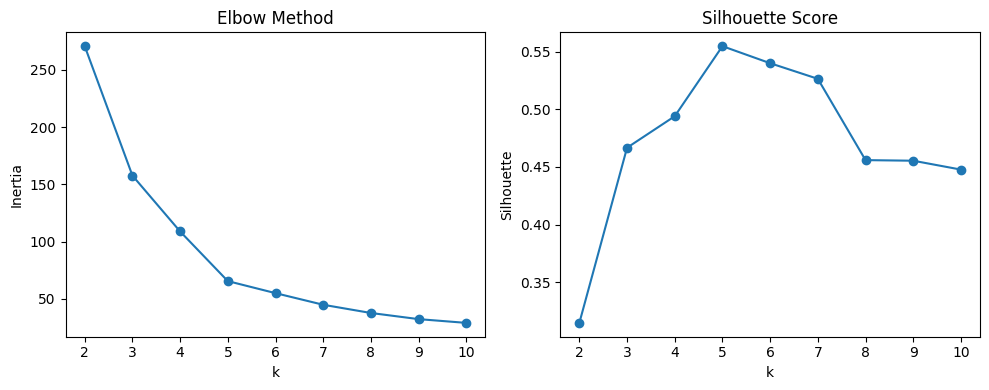

Optimal k (silhouette) = 5

KMeans cluster centers:
   Annual Income (k$)  Spending Score (1-100)  Cluster
0           55.296296               49.518519        0
1           88.200000               17.114286        1
2           26.304348               20.913043        2
3           25.727273               79.363636        3
4           86.538462               82.128205        4


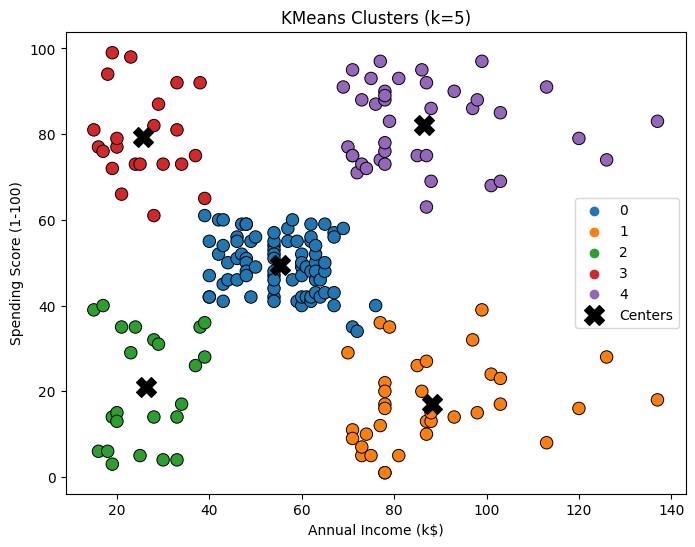

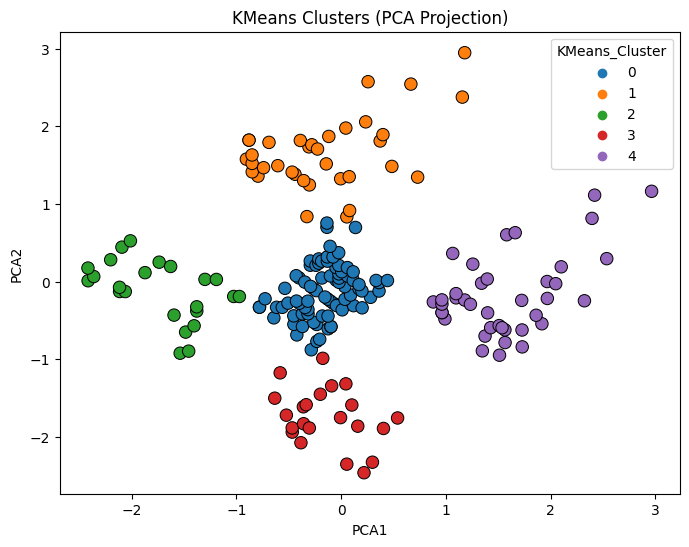

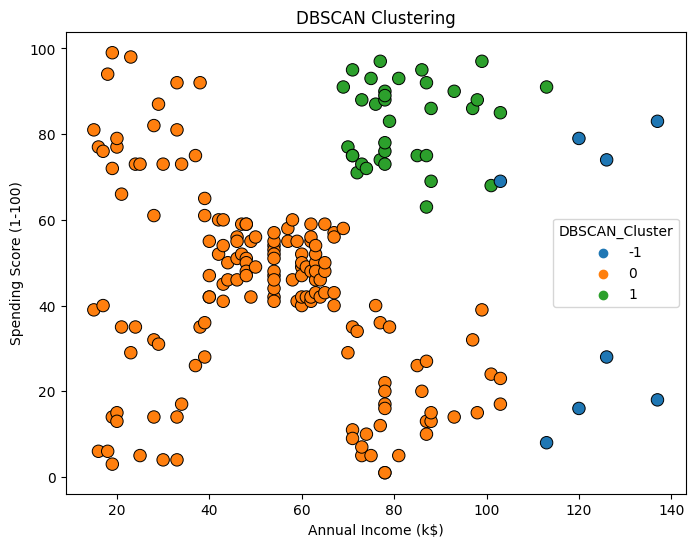


Cluster Analysis:
                customer_count  mean_income  mean_spending_score
KMeans_Cluster                                                  
0                           81    55.296296            49.518519
1                           35    88.200000            17.114286
2                           23    26.304348            20.913043
3                           22    25.727273            79.363636
4                           39    86.538462            82.128205

Saved results to /kaggle/working/


In [1]:
"""
Full Customer Segmentation Pipeline - Kaggle Version
Dataset path: /kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv
"""

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ---------------------------
# 0. Settings
# ---------------------------
DATA_PATH = "/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv"
PLOT_DIR = "/kaggle/working/plots"
os.makedirs(PLOT_DIR, exist_ok=True)
RANDOM_STATE = 42

# ---------------------------
# 1. Load & quick explore
# ---------------------------
df = pd.read_csv(DATA_PATH)
print("Data head:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nDescriptive stats:")
print(df.describe())

# Drop CustomerID if present
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

# Ensure needed columns exist
required_cols = ['Annual Income (k$)', 'Spending Score (1-100)']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in dataset.")

# ---------------------------
# 2. Features & scaling
# ---------------------------
X = df[required_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 3. Elbow & silhouette
# ---------------------------
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(list(K_range), silhouettes, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette Score')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "elbow_silhouette.png"), dpi=150)
plt.show()

optimal_k = list(K_range)[int(np.argmax(silhouettes))]
print(f"Optimal k (silhouette) = {optimal_k}")

# ---------------------------
# 4. K-Means clustering
# ---------------------------
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=20)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster centers in original scale
centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_orig, columns=required_cols)
centers_df['Cluster'] = range(optimal_k)
print("\nKMeans cluster centers:")
print(centers_df)

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='KMeans_Cluster', palette='tab10', data=df, s=80, edgecolor='k'
)
plt.scatter(centers_df['Annual Income (k$)'], centers_df['Spending Score (1-100)'],
            marker='X', s=200, c='black', label='Centers')
plt.legend()
plt.title(f"KMeans Clusters (k={optimal_k})")
plt.savefig(os.path.join(PLOT_DIR, f"kmeans_clusters_k{optimal_k}.png"), dpi=150)
plt.show()

# PCA visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df, palette='tab10', s=80, edgecolor='k')
plt.title('KMeans Clusters (PCA Projection)')
plt.savefig(os.path.join(PLOT_DIR, f"kmeans_pca_k{optimal_k}.png"), dpi=150)
plt.show()

# ---------------------------
# 5. DBSCAN (bonus)
# ---------------------------
db = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = db.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='DBSCAN_Cluster', data=df, palette='tab10', s=80, edgecolor='k')
plt.title("DBSCAN Clustering")
plt.savefig(os.path.join(PLOT_DIR, "dbscan.png"), dpi=150)
plt.show()

# ---------------------------
# 6. Cluster analysis
# ---------------------------
cluster_analysis = df.groupby('KMeans_Cluster').agg(
    customer_count=('KMeans_Cluster','count'),
    mean_income=('Annual Income (k$)', 'mean'),
    mean_spending_score=('Spending Score (1-100)', 'mean')
)
print("\nCluster Analysis:")
print(cluster_analysis)

df.to_csv("/kaggle/working/mall_customers_with_clusters.csv", index=False)
print("\nSaved results to /kaggle/working/")
